In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import CelebA
# Function to convert -1/1 to 0/1 and stack attributes
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

DTYPE = torch.float32
data_path = "C:/Users/manju/Desktop/ECSE 552/Project"

def get_attr_matrix(dataset):
    attr_matrix = np.stack([dataset.attr[i].numpy() for i in range(len(dataset))])
    attr_matrix = (attr_matrix == 1).astype(int)
    return attr_matrix

# Load CelebA splits (no transforms needed for attribute counting)
train_dataset = CelebA(root=data_path, split="train", target_type="attr", download=False)
val_dataset   = CelebA(root=data_path, split="valid", target_type="attr", download=False)
test_dataset  = CelebA(root=data_path, split="test",  target_type="attr", download=False)

# Get attributes and names
ATTRIBUTES = train_dataset.attr_names  # All 40 attributes

# Stack all attributes together
train_attrs = get_attr_matrix(train_dataset)
val_attrs   = get_attr_matrix(val_dataset)
test_attrs  = get_attr_matrix(test_dataset)
ATTRIBUTES = ATTRIBUTES[:40]
all_attrs = np.concatenate([train_attrs, val_attrs, test_attrs], axis=0)

# Count 1s and 0s
ones_count = all_attrs.sum(axis=0)
zeros_count = all_attrs.shape[0] - ones_count

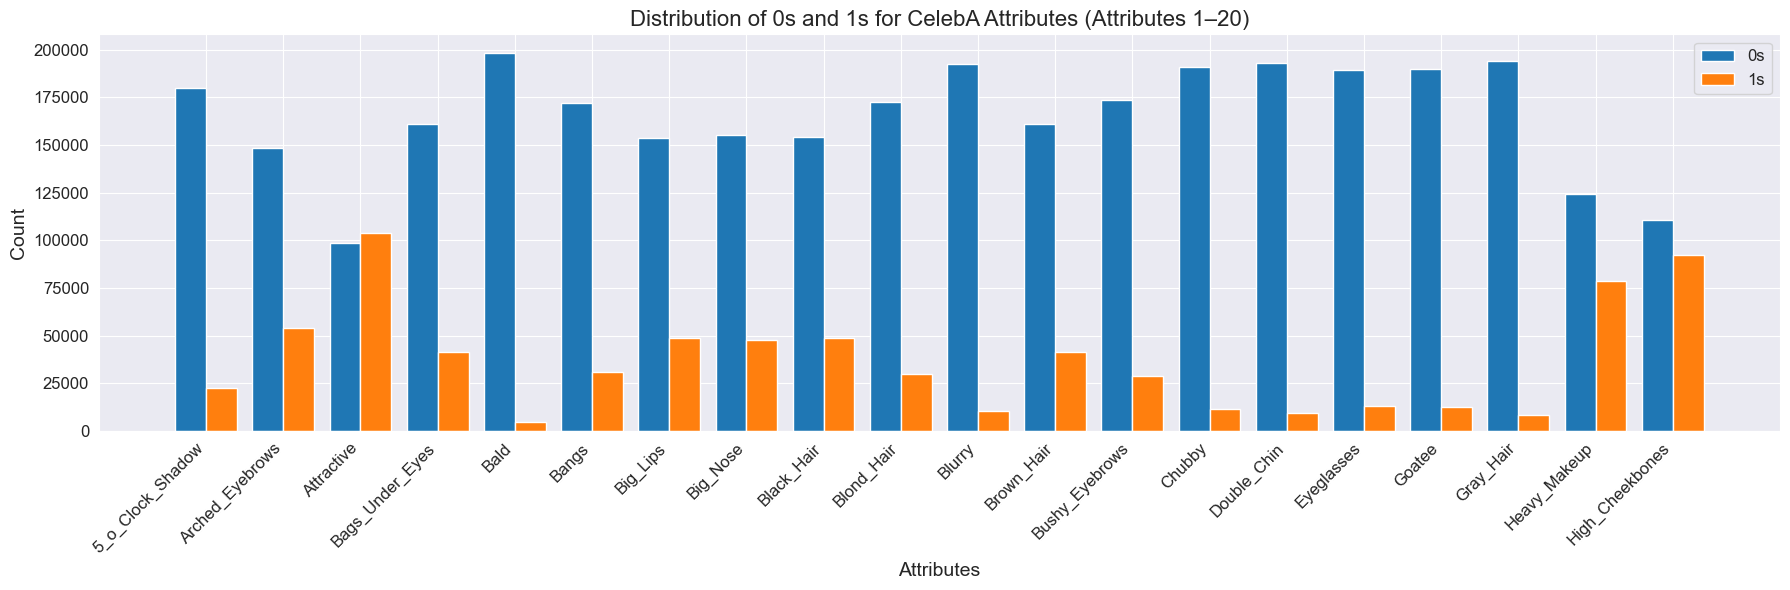

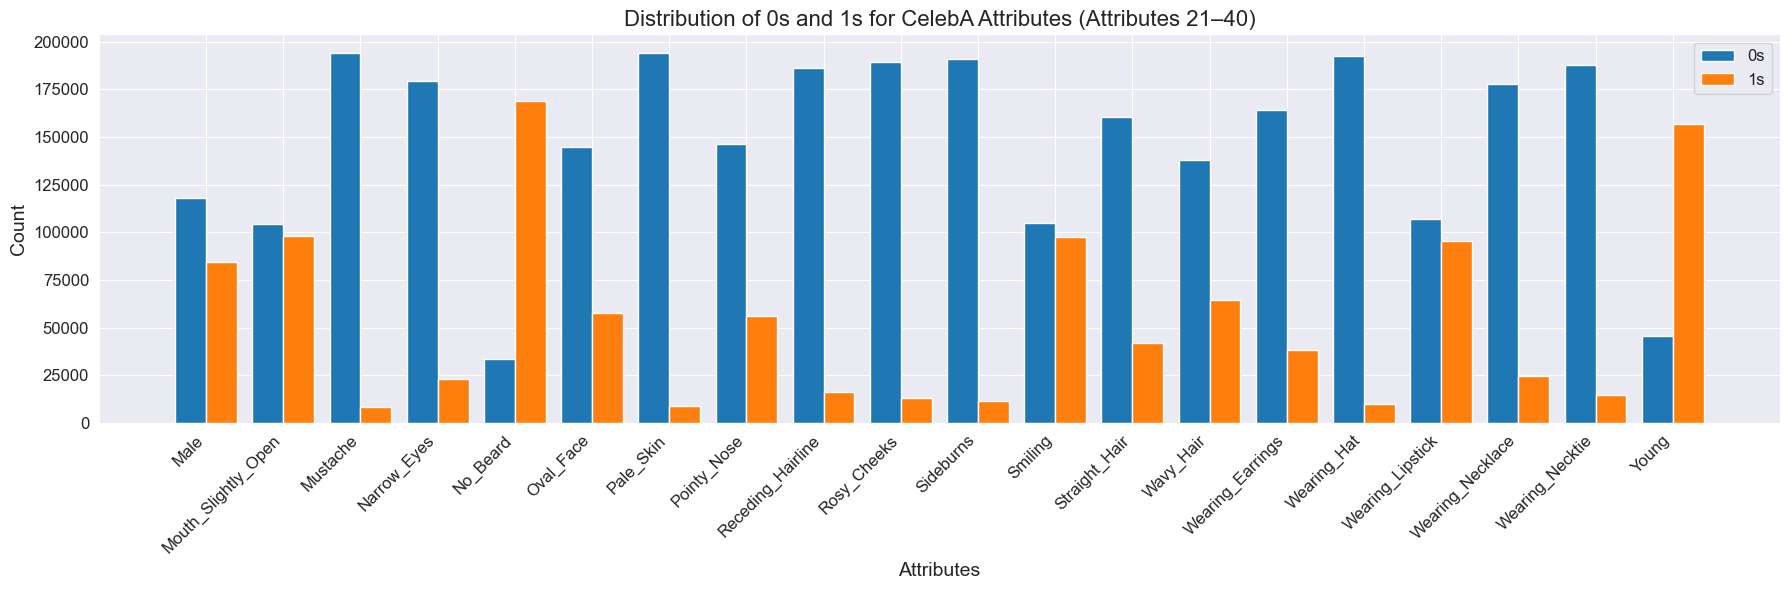

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming zeros_count, ones_count, and ATTRIBUTES are already defined
chunk_size = 20
num_chunks = (len(ATTRIBUTES) + chunk_size - 1) // chunk_size

x = np.arange(len(ATTRIBUTES))
width = 0.4

for i in range(num_chunks):
    start = i * chunk_size
    end = min((i + 1) * chunk_size, len(ATTRIBUTES))
    
    attr_chunk = ATTRIBUTES[start:end]
    x_chunk = np.arange(len(attr_chunk))
    zeros_chunk = zeros_count[start:end]
    ones_chunk = ones_count[start:end]

    plt.figure(figsize=(18, 6))
    plt.bar(x_chunk - width/2, zeros_chunk, width, label='0s')
    plt.bar(x_chunk + width/2, ones_chunk, width, label='1s')
    plt.xlabel('Attributes', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title(f'Distribution of 0s and 1s for CelebA Attributes (Attributes {start+1}–{end})', fontsize=16)
    plt.xticks(x_chunk, attr_chunk, rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    # Save the plot
    filename = f"attribute_dist_{i+1}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


In [1]:

def evaluate_saved_csv_aligned(csv_path):
    df = pd.read_csv(csv_path)

    pred_cols = sorted([col for col in df.columns if col.startswith("pred_")])
    true_cols = sorted([col for col in df.columns if col.startswith("true_")])

    pred_attr_names = [col.replace("pred_", "") for col in pred_cols]
    true_attr_names = [col.replace("true_", "") for col in true_cols]

    assert pred_attr_names == true_attr_names, "Attribute mismatch!"

    preds = df[pred_cols].values.astype(int)
    labels = df[true_cols].values.astype(int)
    attribute_names = pred_attr_names

    # Element-wise (micro) accuracy across all entries
    overall_accuracy = (preds == labels).astype(np.float32).mean()

    # Macro-averaged metrics
    macro_precision = precision_score(labels, preds, average='macro', zero_division=0)
    macro_recall = recall_score(labels, preds, average='macro', zero_division=0)
    macro_f1 = f1_score(labels, preds, average='macro', zero_division=0)
    
    micro_precision = precision_score(labels, preds, average='micro', zero_division=0)
    micro_recall = recall_score(labels, preds, average='micro', zero_division=0)
    micro_f1 = f1_score(labels, preds, average='micro', zero_division=0)

    overall = {
        "elementwise_accuracy": overall_accuracy,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1,
        # "micro_precision": micro_precision,
        # "micro_recall": micro_recall,
        # "micro_f1": micro_f1
    }

    # Per-attribute metrics
    per_attr = []
    for i, attr in enumerate(attribute_names):
        p = precision_score(labels[:, i], preds[:, i], zero_division=0)
        r = recall_score(labels[:, i], preds[:, i], zero_division=0)
        f = f1_score(labels[:, i], preds[:, i], zero_division=0)
        acc = (preds[:, i] == labels[:, i]).astype(np.float32).mean()
        per_attr.append({
            "attribute": attr,
            "accuracy": acc,
            "precision": p,
            "recall": r,
            "f1": f
        })

    per_attr_df = pd.DataFrame(per_attr).set_index("attribute")
    return overall, per_attr_df

model_paths = {
    "FCNN Baseline": "fcnn_test_results.csv",
    "CNN Baseline": "cnn_basic_results_1.csv",
    "Custom CNN": "cnn_test_results.csv",
    "Vision Transformer": "transformer_test_results.csv",
}


overall_metrics = {}
per_attribute_dfs = {}

for model_name, file_path in model_paths.items():
    overall, per_attr = evaluate_saved_csv_aligned(file_path)
    overall_metrics[model_name] = overall
    per_attribute_dfs[model_name] = per_attr


In [20]:
overall_df = pd.DataFrame(overall_metrics).T.round(4)
print("🔍 Overall Model Comparison:")
display(overall_df)


🔍 Overall Model Comparison:


,elementwise_accuracy,macro_precision,macro_recall,macro_f1
FCNN Baseline,0.2358,0.2314,1.0000,0.3374
CNN Baseline,0.8903,0.7207,0.5288,0.5871
Custom CNN,0.9124,0.7719,0.6933,0.7223
Vision Transformer,0.9116,0.7733,0.6631,0.6999


C:\Users\manju\AppData\Local\Temp\ipykernel_55140\504744057.py:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\manju\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


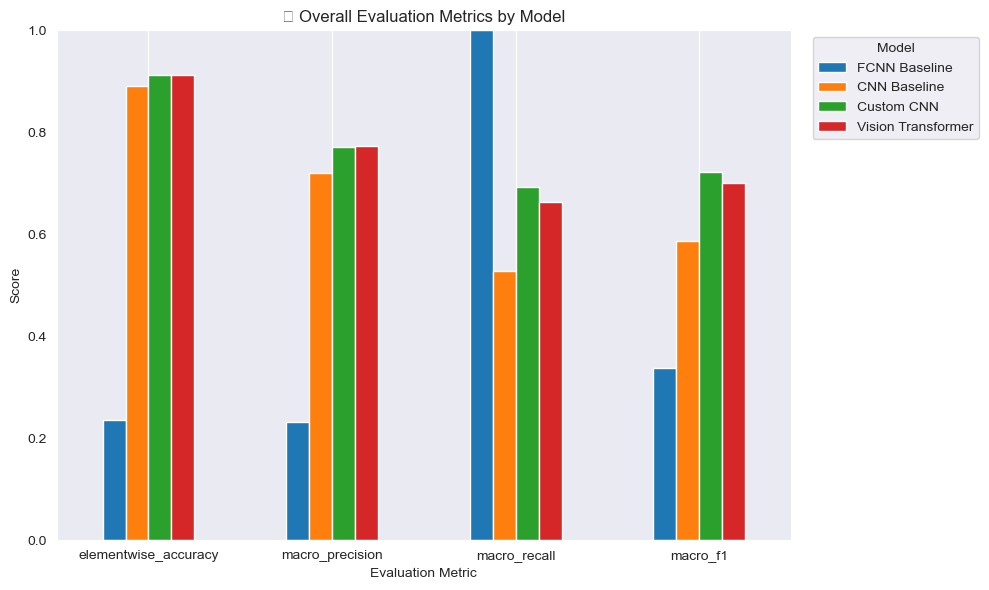

In [21]:
# Overall Metrics Plot
import matplotlib.pyplot as plt
# Flip the overall_df for correct orientation
overall_df_flipped = overall_df.T  # Transpose: metrics as rows, models as columns

# Plot
overall_df_flipped.plot(kind='bar', figsize=(10, 6))

plt.title("📊 Overall Evaluation Metrics by Model")
plt.xlabel("Evaluation Metric")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.legend(title="Model", bbox_to_anchor=(1.02, 1), loc='upper left')  # Legend as models
plt.tight_layout()
plt.show()


C:\Users\manju\AppData\Local\Temp\ipykernel_55140\2648062494.py:17: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from current font.
  plt.tight_layout()
C:\Users\manju\AppData\Local\Temp\ipykernel_55140\2648062494.py:20: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\manju\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


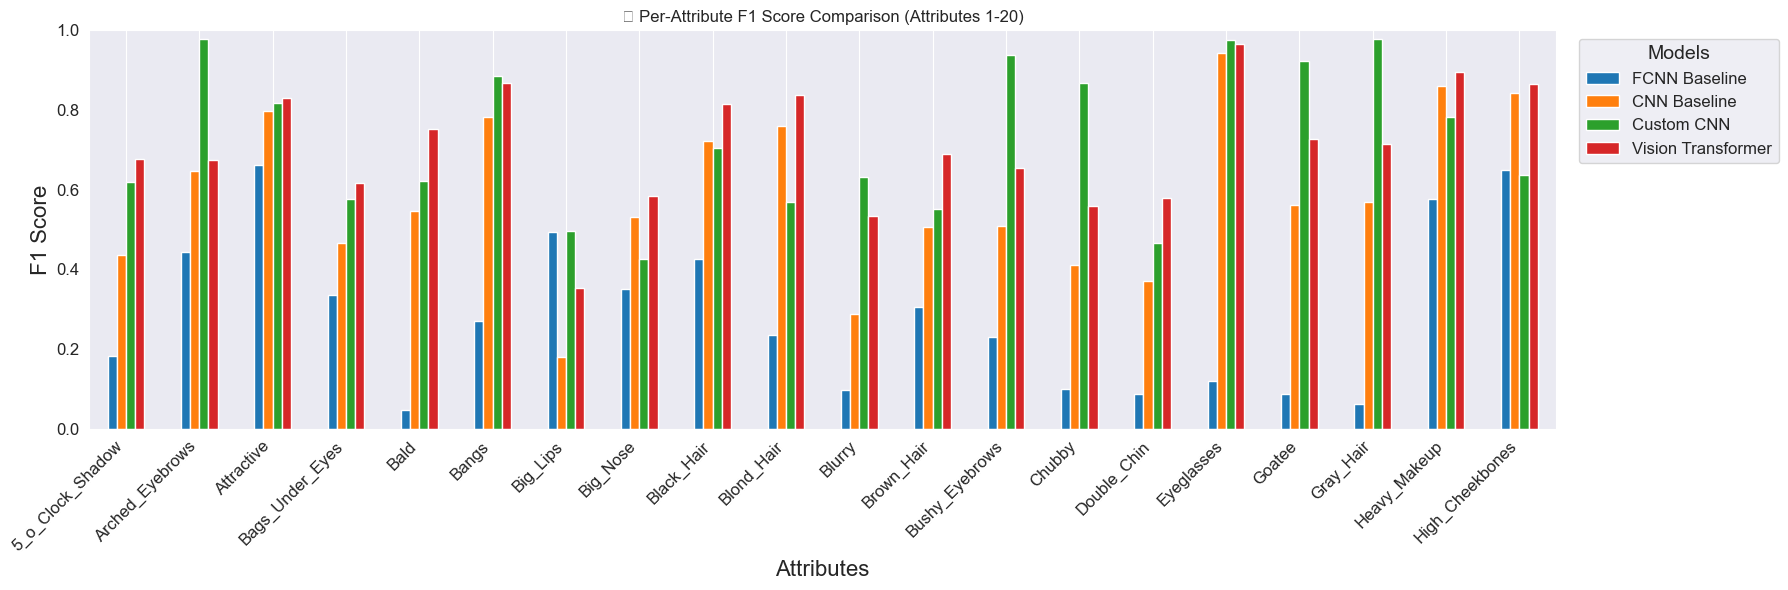

C:\Users\manju\AppData\Local\Temp\ipykernel_55140\2648062494.py:17: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from current font.
  plt.tight_layout()
C:\Users\manju\AppData\Local\Temp\ipykernel_55140\2648062494.py:20: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\manju\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


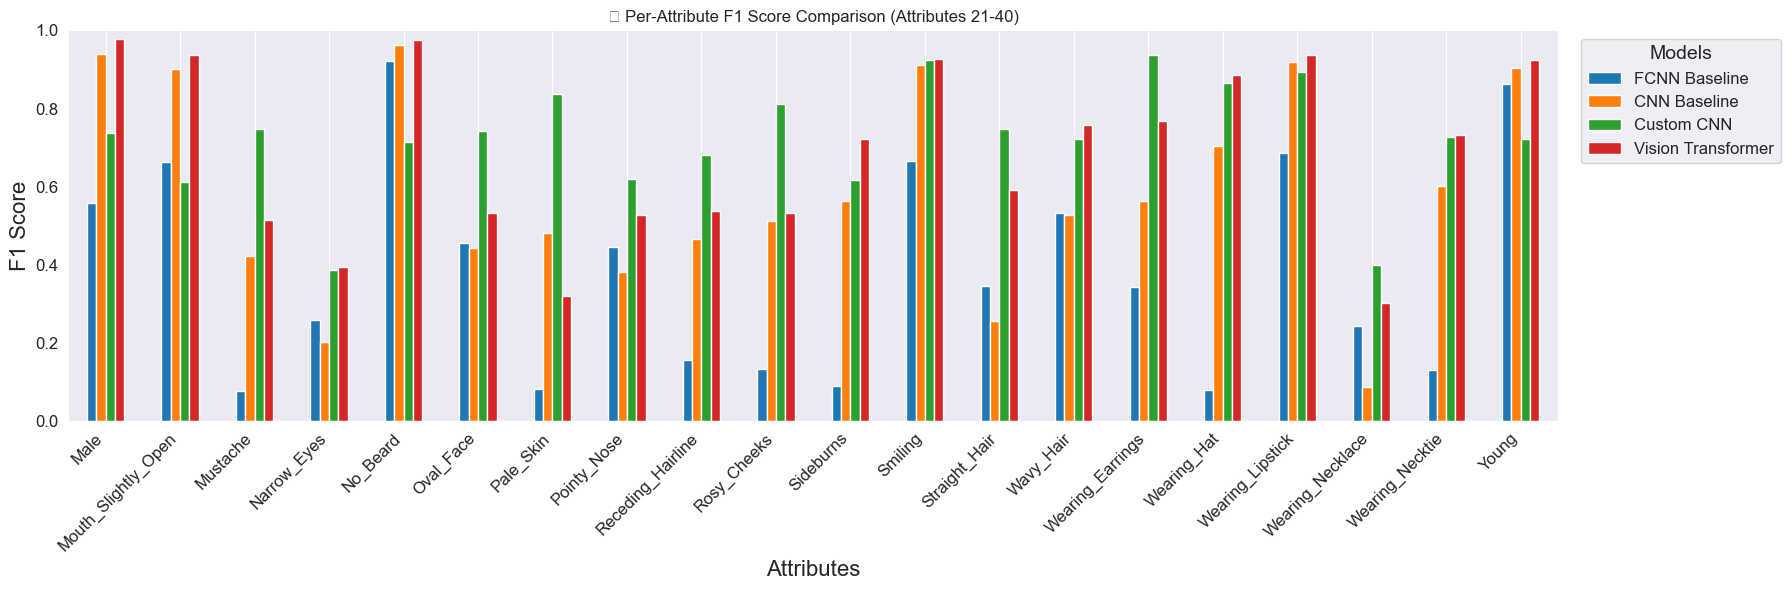

C:\Users\manju\AppData\Local\Temp\ipykernel_55140\2648062494.py:17: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
C:\Users\manju\AppData\Local\Temp\ipykernel_55140\2648062494.py:20: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\manju\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


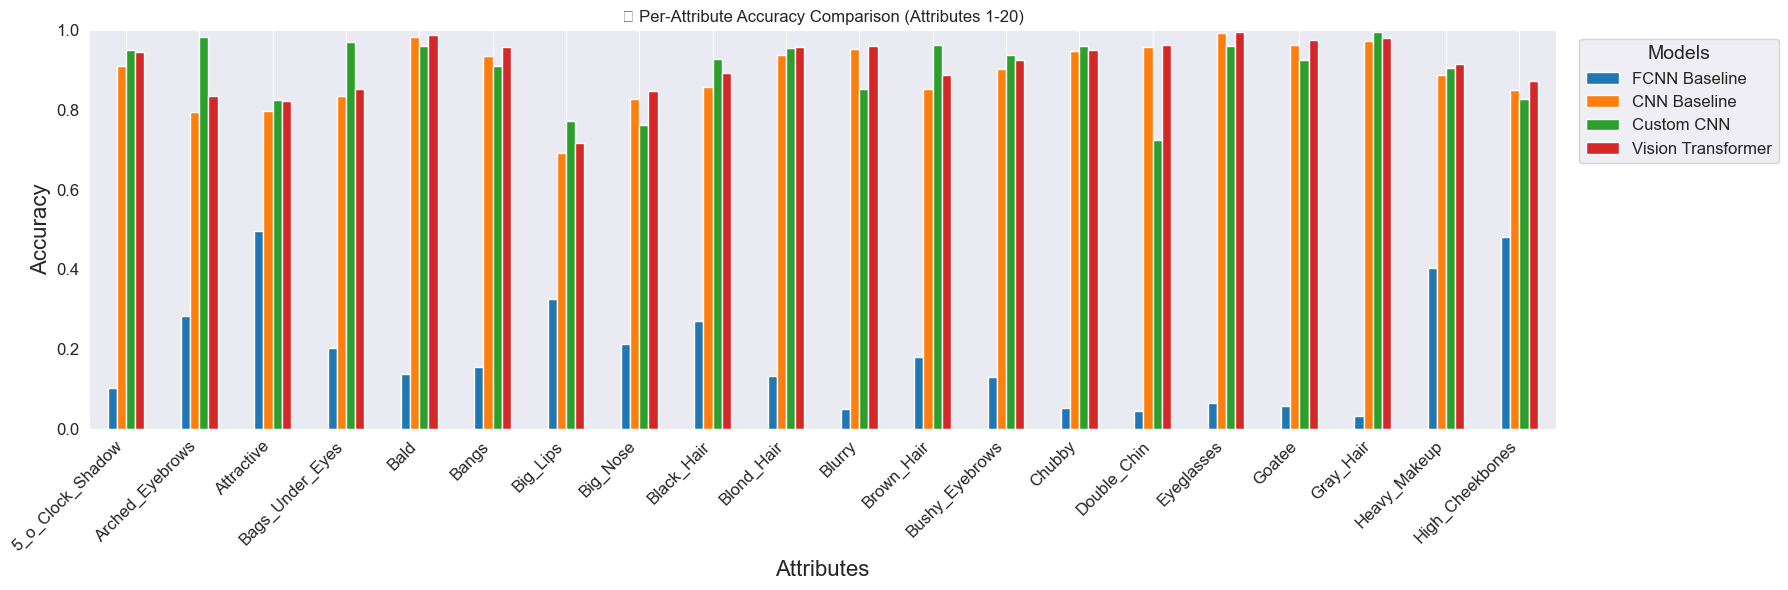

C:\Users\manju\AppData\Local\Temp\ipykernel_55140\2648062494.py:17: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
C:\Users\manju\AppData\Local\Temp\ipykernel_55140\2648062494.py:20: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\manju\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


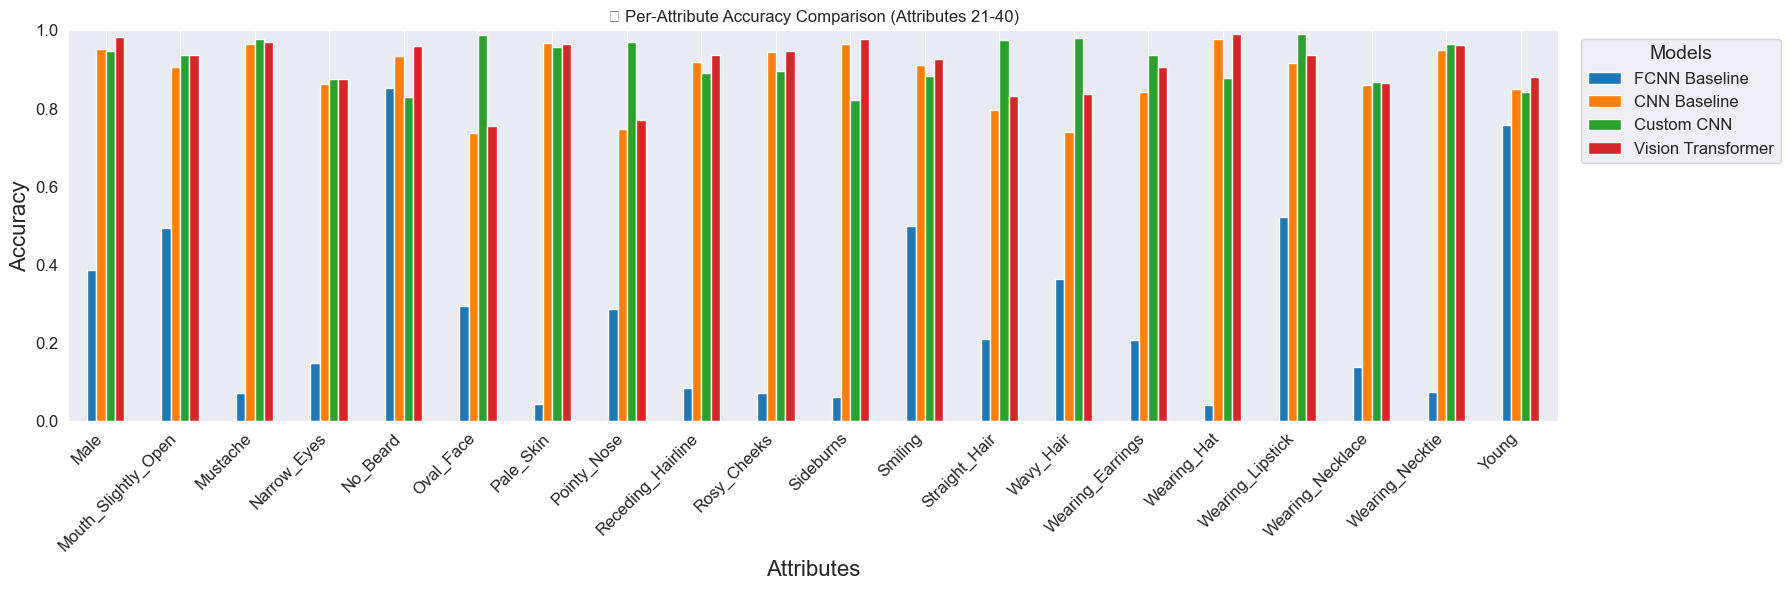

In [25]:
def plot_metric_in_chunks(df, metric_name, ylabel, title_icon, prefix):
    chunk_size = 20
    num_chunks = (len(df) + chunk_size - 1) // chunk_size

    for i in range(num_chunks):
        chunk = df.iloc[i * chunk_size:(i + 1) * chunk_size]
        ax = chunk.plot(kind='bar', figsize=(18, 6),
                        title=f"{title_icon} Per-Attribute {metric_name} Comparison (Attributes {i*chunk_size + 1}-{min((i+1)*chunk_size, len(df))})",
                        fontsize=14)
        plt.ylabel(ylabel, fontsize=16)
        plt.xlabel("Attributes", fontsize=16)
        plt.ylim(0, 1)
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(axis='y')
        plt.legend(title="Models", fontsize=12, title_fontsize=14, bbox_to_anchor=(1.01, 1), loc='upper left')
        plt.tight_layout()
        # Save each plot
        filename = f"{prefix}_{i+1}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()

# Save F1 plots
plot_metric_in_chunks(f1_df, metric_name="F1 Score", ylabel="F1 Score", title_icon="🔬", prefix="f1_plot")

# Save Accuracy plots
plot_metric_in_chunks(acc_df, metric_name="Accuracy", ylabel="Accuracy", title_icon="🎯", prefix="accuracy_plot")


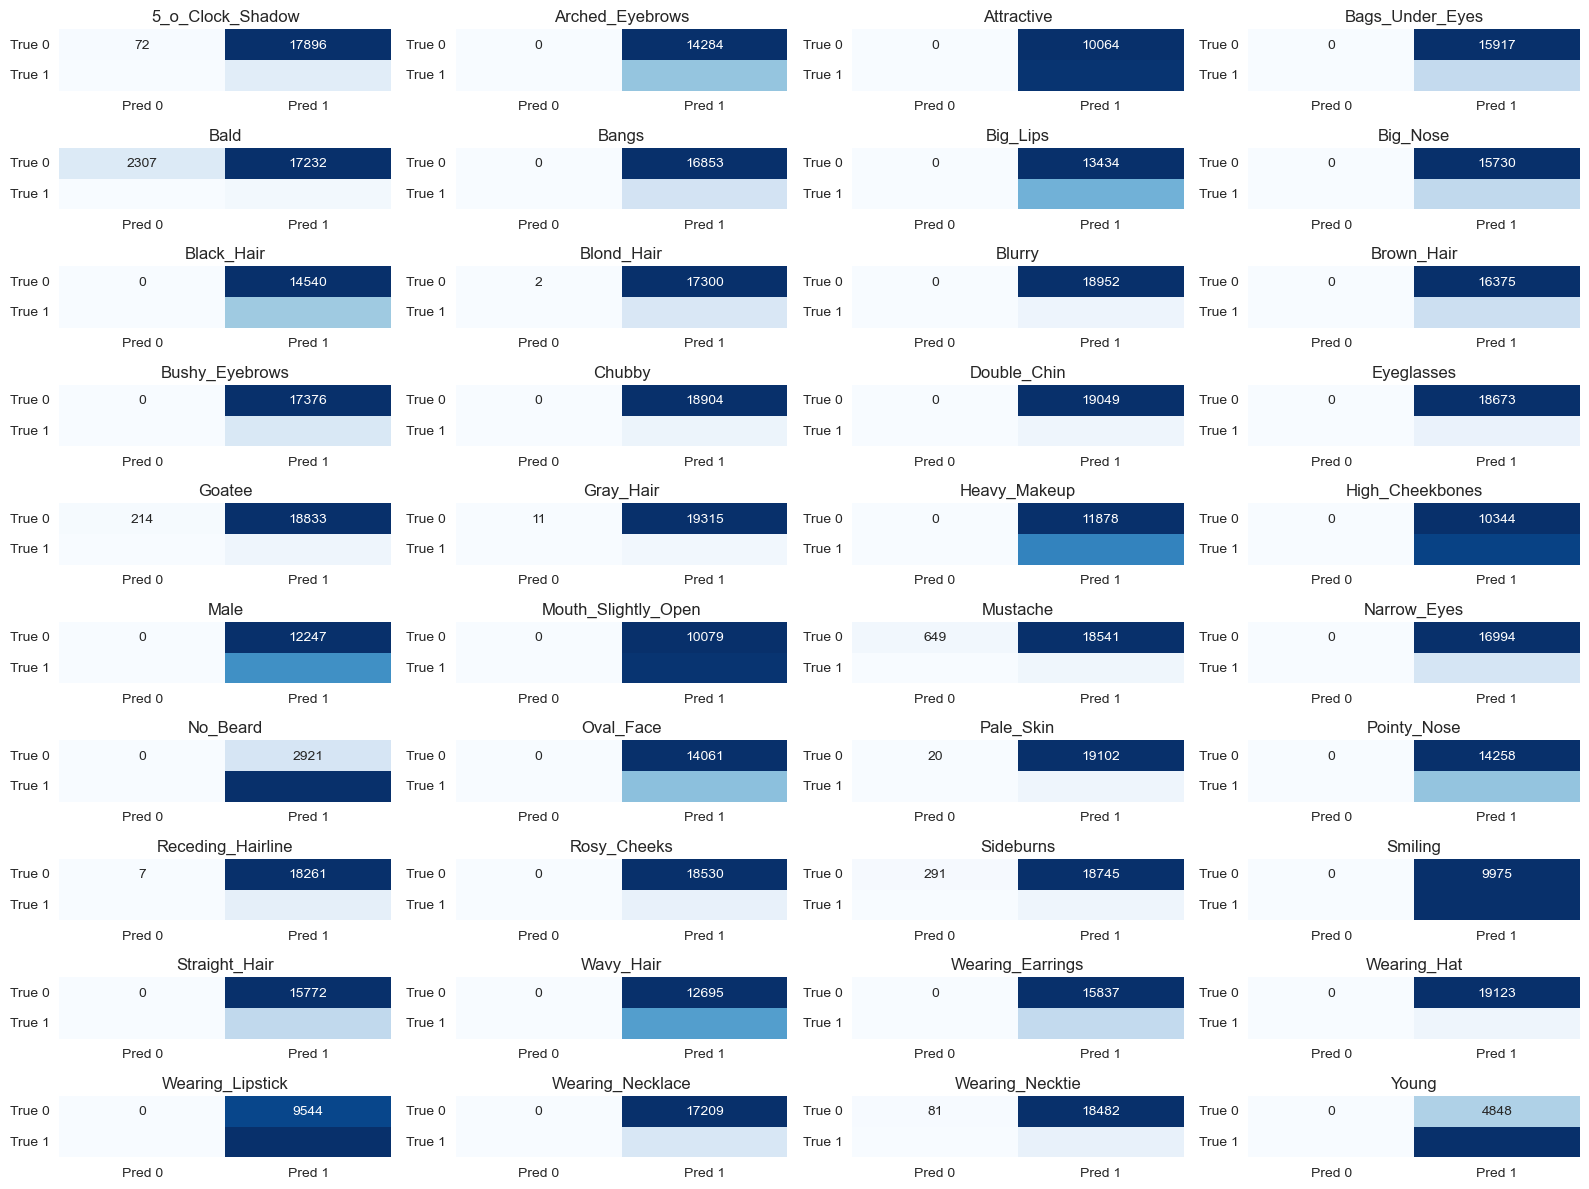

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices_grid(df, label_prefix='true_', pred_prefix='pred_', figsize=(16, 12)):
    # Get label and prediction column names
    true_cols = sorted([col for col in df.columns if col.startswith(label_prefix)])
    pred_cols = sorted([col for col in df.columns if col.startswith(pred_prefix)])
    
    num_labels = len(true_cols)
    ncols = 4
    nrows = (num_labels + ncols - 1) // ncols  # Grid shape

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    for i in range(num_labels):
        true = df[true_cols[i]]
        pred = df[pred_cols[i]]
        cm = confusion_matrix(true, pred, labels=[0, 1])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Pred 0', 'Pred 1'],
                    yticklabels=['True 0', 'True 1'],
                    ax=axes[i])
        axes[i].set_title(true_cols[i].replace(label_prefix, ''))

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Example usage:
df = pd.read_csv("fcnn_test_results.csv")
plot_confusion_matrices_grid(df)

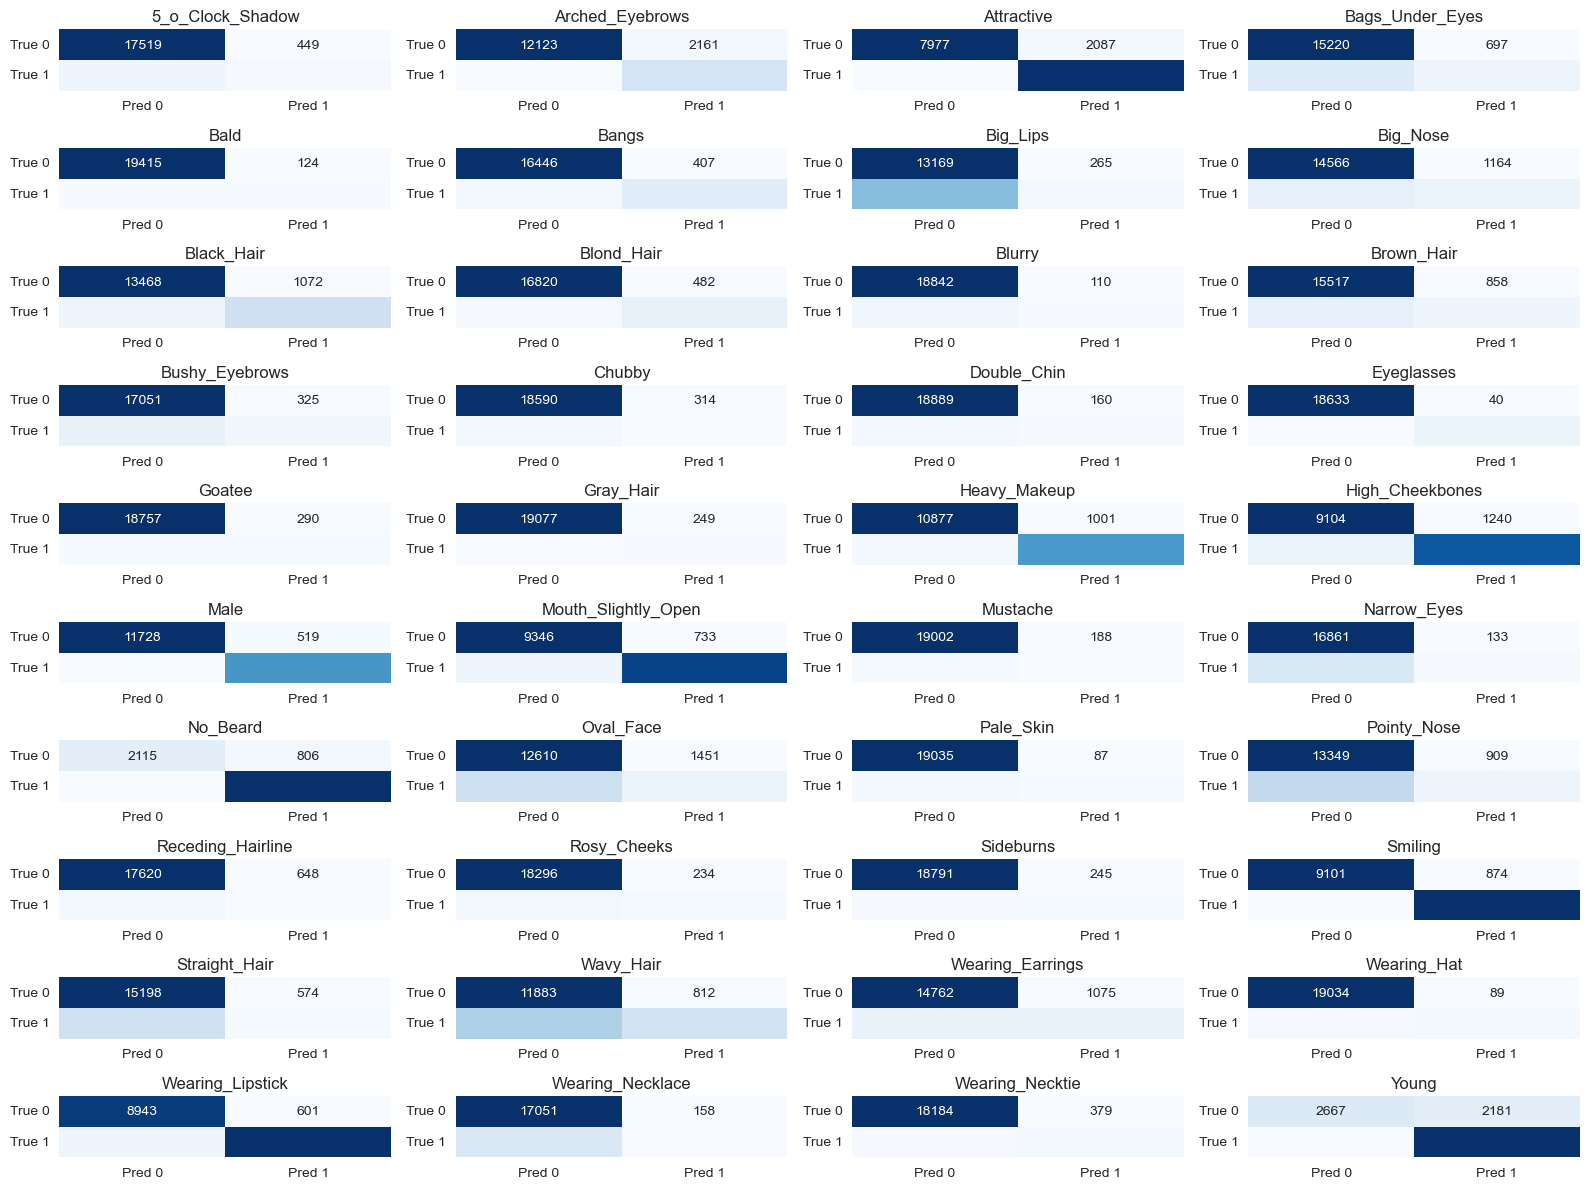

In [8]:
df = pd.read_csv("cnn_basic_results_1.csv")
plot_confusion_matrices_grid(df)

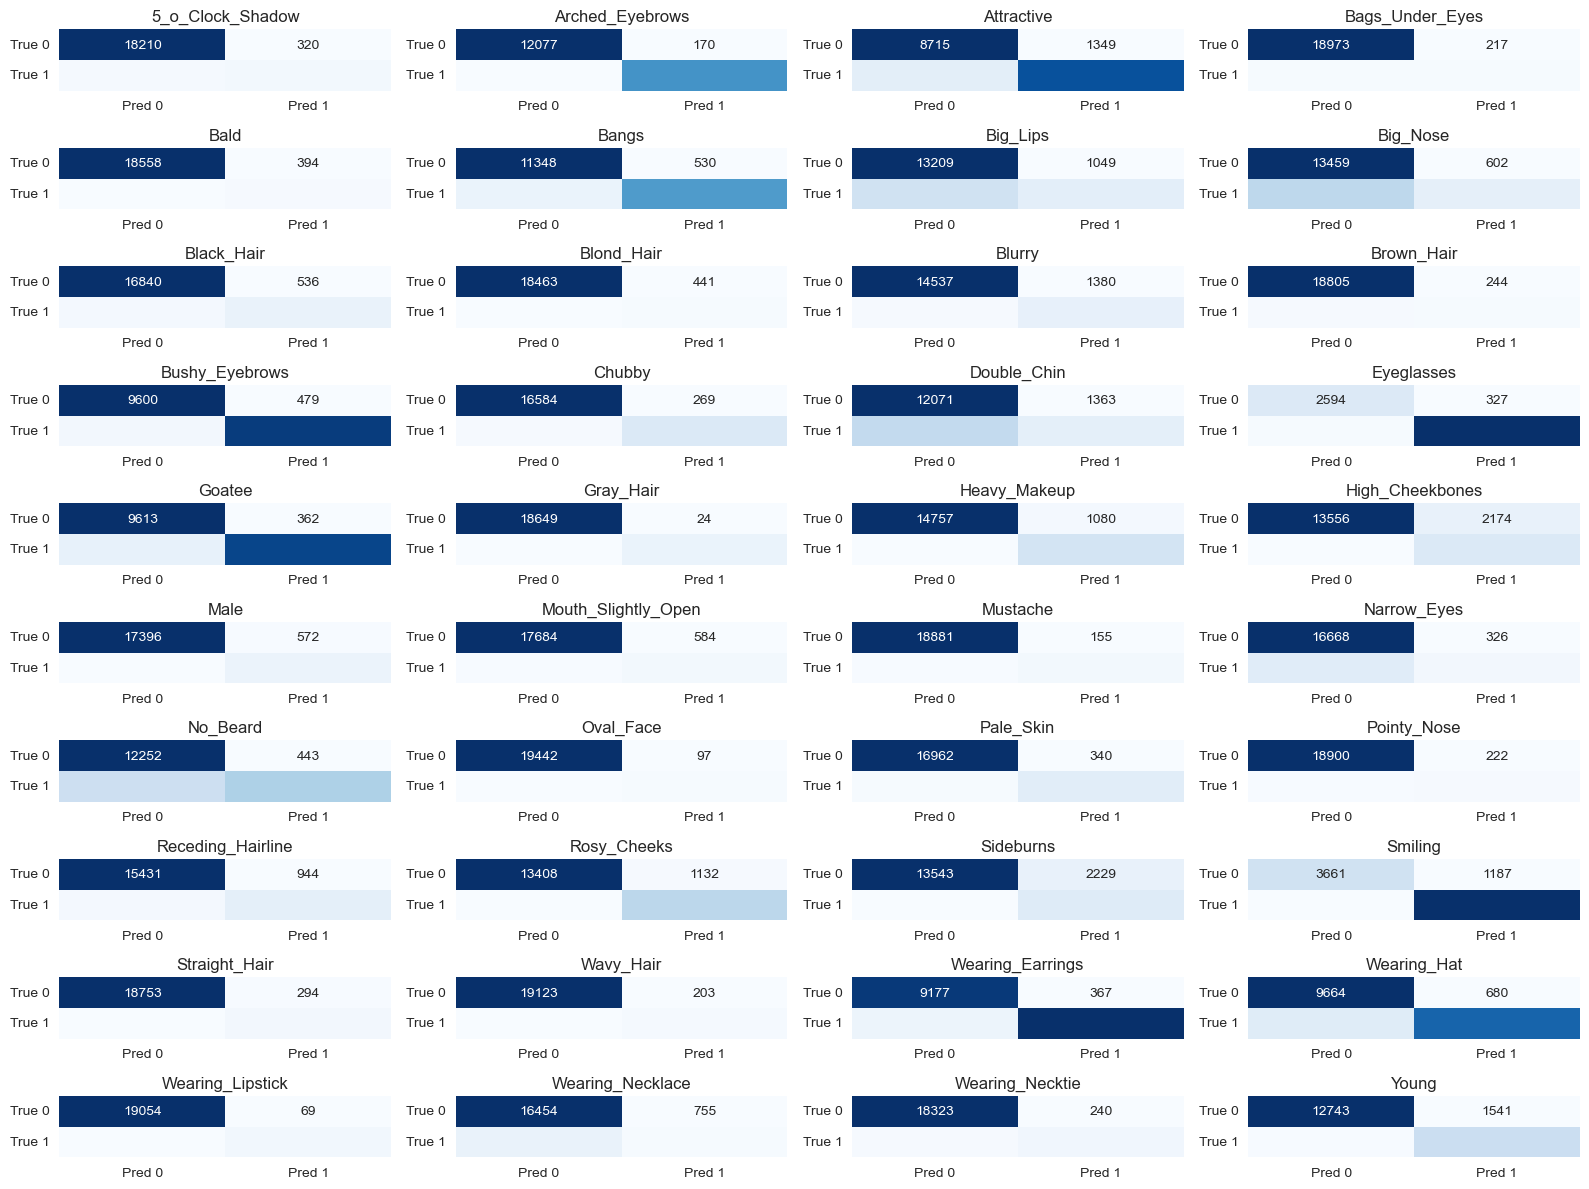

In [9]:
df = pd.read_csv("cnn_test_results.csv")
plot_confusion_matrices_grid(df)

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

def evaluate_saved_csv_aligned(csv_path, interested_attrs=None):
    df = pd.read_csv(csv_path)

    pred_cols = sorted([col for col in df.columns if col.startswith("pred_")])
    true_cols = sorted([col for col in df.columns if col.startswith("true_")])

    pred_attr_names = [col.replace("pred_", "") for col in pred_cols]
    true_attr_names = [col.replace("true_", "") for col in true_cols]

    assert pred_attr_names == true_attr_names, "Attribute mismatch!"

    preds = df[pred_cols].values.astype(int)
    labels = df[true_cols].values.astype(int)
    attribute_names = pred_attr_names

    if interested_attrs:
        indices = [attribute_names.index(attr) for attr in interested_attrs]
    else:
        indices = range(len(attribute_names))

    # Element-wise (micro) accuracy across all entries
    overall_accuracy = (preds == labels).astype(np.float32).mean()

    # Macro-averaged metrics
    macro_precision = precision_score(labels, preds, average='macro', zero_division=0)
    macro_recall = recall_score(labels, preds, average='macro', zero_division=0)
    macro_f1 = f1_score(labels, preds, average='macro', zero_division=0)

    overall = {
        "elementwise_accuracy": overall_accuracy,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1
    }

    # Per-attribute metrics
    per_attr = []
    for i in indices:
        attr = attribute_names[i]
        y_true = labels[:, i]
        y_pred = preds[:, i]
        
        acc = accuracy_score(y_true, y_pred)
        p = precision_score(y_true, y_pred, zero_division=0)
        r = recall_score(y_true, y_pred, zero_division=0)
        f = f1_score(y_true, y_pred, zero_division=0)

        # Confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        
        # 1-to-0 ratio in true labels
        one_count = np.sum(y_true == 1)
        zero_count = np.sum(y_true == 0)
        ratio_1_to_0 = one_count / (zero_count+one_count) if zero_count > 0 else float('inf')

        per_attr.append({
            "attribute": attr,
            "accuracy": acc,
            "precision": p,
            "recall": r,
            "f1": f,
            "true_1_to_0_ratio": ratio_1_to_0,
            "tp": tp,
            "tn": tn,
            "fp": fp,
            "fn": fn
        })

    per_attr_df = pd.DataFrame(per_attr).set_index("attribute")
    return overall, per_attr_df


In [16]:
csv_path = "fcnn_test_results.csv"
interested_attrs = ['Eyeglasses', 'Male', 'Mouth_Slightly_Open', 'Wearing_Hat','Wearing_Earrings','Wearing_Necklace', 'Wearing_Necktie']  # or None for all
overall, detailed_metrics = evaluate_saved_csv_aligned(csv_path, interested_attrs)
print("Overall Metrics:\n", overall)
print("\nDetailed Per-Attribute Metrics:\n", detailed_metrics)

Overall Metrics:
 {'elementwise_accuracy': 0.23583183, 'macro_precision': 0.23140567372467982, 'macro_recall': 1.0, 'macro_f1': 0.33735750936580267}

Detailed Per-Attribute Metrics:
                      accuracy  precision  recall        f1  true_1_to_0_ratio  \
attribute                                                                       
Eyeglasses           0.064573   0.064573     1.0  0.121312           0.064573   
Male                 0.386484   0.386484     1.0  0.557503           0.386484   
Mouth_Slightly_Open  0.495091   0.495091     1.0  0.662288           0.495091   
Wearing_Hat          0.042030   0.042030     1.0  0.080669           0.042030   
Wearing_Earrings     0.206643   0.206643     1.0  0.342508           0.206643   
Wearing_Necklace     0.137912   0.137912     1.0  0.242395           0.137912   
Wearing_Necktie      0.074141   0.070369     1.0  0.131485           0.070083   

                       tp  tn     fp  fn  
attribute                                 
E

In [17]:
csv_path = "cnn_basic_results_1.csv"
interested_attrs = ['Eyeglasses', 'Male', 'Mouth_Slightly_Open', 'Wearing_Hat','Wearing_Earrings','Wearing_Necklace', 'Wearing_Necktie']  # or None for all
overall, detailed_metrics = evaluate_saved_csv_aligned(csv_path, interested_attrs)
print("Overall Metrics:\n", overall)
print("\nDetailed Per-Attribute Metrics:\n", detailed_metrics)

Overall Metrics:
 {'elementwise_accuracy': 0.89025396, 'macro_precision': 0.7207072978759352, 'macro_recall': 0.5287533606085306, 'macro_f1': 0.587121371508813}

Detailed Per-Attribute Metrics:
                      accuracy  precision    recall        f1  \
attribute                                                      
Eyeglasses           0.992987   0.967453  0.922420  0.944400   
Male                 0.953512   0.933674  0.946986  0.940283   
Mouth_Slightly_Open  0.905120   0.922475  0.882526  0.902058   
Wearing_Hat          0.978810   0.850168  0.601907  0.704815   
Wearing_Earrings     0.841799   0.655117  0.495030  0.563933   
Wearing_Necklace     0.860836   0.457045  0.048311  0.087385   
Wearing_Necktie      0.949354   0.669284  0.548249  0.602750   

                     true_1_to_0_ratio    tp     tn    fp    fn  
attribute                                                        
Eyeglasses                    0.064573  1189  18633    40   100  
Male                          

In [18]:
csv_path = "cnn_test_results.csv"
interested_attrs = ['Eyeglasses', 'Male', 'Mouth_Slightly_Open', 'Wearing_Hat','Wearing_Earrings','Wearing_Necklace', 'Wearing_Necktie']  # or None for all
overall, detailed_metrics = evaluate_saved_csv_aligned(csv_path, interested_attrs)
print("Overall Metrics:\n", overall)
print("\nDetailed Per-Attribute Metrics:\n", detailed_metrics)

Overall Metrics:
 {'elementwise_accuracy': 0.9124399, 'macro_precision': 0.7719467173554122, 'macro_recall': 0.6932839747645723, 'macro_f1': 0.7223332714240697}

Detailed Per-Attribute Metrics:
                      accuracy  precision    recall        f1  \
attribute                                                      
Eyeglasses           0.960325   0.980654  0.972713  0.976667   
Male                 0.946649   0.724071  0.752758  0.738136   
Mouth_Slightly_Open  0.936129   0.632010  0.592090  0.611399   
Wearing_Hat          0.878419   0.920477  0.818361  0.866421   
Wearing_Earrings     0.936880   0.962899  0.914283  0.937962   
Wearing_Necklace     0.868300   0.537944  0.319288  0.400729   
Wearing_Necktie      0.964683   0.795571  0.667620  0.726001   

                     true_1_to_0_ratio     tp     tn   fp    fn  
attribute                                                        
Eyeglasses                    0.853672  16576   2594  327   465  
Male                          

In [19]:
csv_path = "transformer_test_results.csv"
interested_attrs = ['Eyeglasses', 'Male', 'Mouth_Slightly_Open', 'Wearing_Hat','Wearing_Earrings','Wearing_Necklace', 'Wearing_Necktie']  # or None for all
overall, detailed_metrics = evaluate_saved_csv_aligned(csv_path, interested_attrs)
print("Overall Metrics:\n", overall)
print("\nDetailed Per-Attribute Metrics:\n", detailed_metrics)

Overall Metrics:
 {'elementwise_accuracy': 0.911572, 'macro_precision': 0.7733433133438676, 'macro_recall': 0.6630763413191492, 'macro_f1': 0.6999259620231272}

Detailed Per-Attribute Metrics:
                      accuracy  precision    recall        f1  \
attribute                                                      
Eyeglasses           0.995592   0.980785  0.950349  0.965327   
Male                 0.983519   0.978616  0.978743  0.978679   
Mouth_Slightly_Open  0.937832   0.944730  0.928767  0.936680   
Wearing_Hat          0.990432   0.882075  0.891538  0.886781   
Wearing_Earrings     0.907374   0.799002  0.737212  0.766864   
Wearing_Necklace     0.866146   0.537674  0.209953  0.301985   
Wearing_Necktie      0.961527   0.714189  0.751966  0.732591   

                     true_1_to_0_ratio    tp     tn   fp    fn  
attribute                                                       
Eyeglasses                    0.064573  1225  18649   24    64  
Male                          0.38